### Goal : Understand how the classifier's performance changes in different regions of the feature space

### Initially start with energy and then generalize to other features

In [2]:
## Imports
import sys
import os
import time
import math
import random

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [3]:
# Label dict
label_dict = {0:"gamma", 1:"e", 2:"mu"}

# Fix the colour scheme for each particle type
color_dict = {"gamma":"red", "e":"blue", "mu":"green"}

# Fix the numpy seed
np.random.seed(42)

### Modify the plot_ROC method to give us the values we need, namely, background rejection at different signal efficiencies

In [14]:
# Plot the ROC curve for one vs another class
def plot_ROC(softmaxes, labels, energies, softmax_index_dict, label_0, label_1, 
             min_energy=0, max_energy=1500, show_plot=False, save_path=None):
    
    assert softmaxes is not None
    assert labels is not None
    assert softmax_index_dict  is not None
    assert softmaxes.shape[0] == labels.shape[0]
    assert label_0 in softmax_index_dict.keys()
    assert label_1 in softmax_index_dict.keys()
    
    # Signal efficiency and background rejection values to return
    sef_values = []
    brj_values = []
    
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    energy_mask               = np.logical_and(energies >= min_energy, energies <= max_energy)
    curr_softmax, curr_labels = softmaxes[energy_mask], labels[energy_mask]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the softmax and true label values only for the two labels given by the user
    label_mask      = np.logical_or(curr_labels==softmax_index_dict[label_0],
                                    curr_labels==softmax_index_dict[label_1])
    
    softmax, labels = curr_softmax[label_mask], curr_labels[label_mask]
    
    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]],
                                    pos_label=softmax_index_dict[label_0])
    roc_auc             = auc(fpr, tpr)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)
        
    if show_plot or save_path is not None:
        
        # TNR vs TPR plot
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)

        ax.plot(tpr, inv_fpr, color=color_dict[label_1],
                 label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=color_dict[label_1])

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(min_energy,2), round(max_energy,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        plt.yscale("log")
        
    # Show coords of individual points near x = 0.2, 0.5, 0.8
    # todo = {0.2: True, 0.5: True, 0.8: True}
    todo = {0.2: True, 0.5: True, 0.8: True}
    
    for xy in zip(tpr, inv_fpr):
            xy = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    brj_values.append(xy[1])
                    
                    if show_plot or save_path is not None:
                        ax.annotate('(%s, %s)' % xy, xy=xy, textcoords='data',
                                    fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False
        
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc, todo.keys(), brj_values

In [15]:
"""num_samples = [45000, 45000, 45000]
run_ids = ["20191024_164716", "20191024_165414", "20191024_170156"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
label_dict = {"gamma":0, "e":1, "mu":2}

for num_sample, run_id in zip(num_samples, run_ids):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for LeNet CNN trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np['softmax'].reshape(-1, 3)
    test_labels   = test_dump_np['labels'].reshape(-1)
    test_energies = test_dump_np['energies'].reshape(-1)
    
    _, _, _, _, sef_values, brj_values = plot_ROC(test_softmax, test_labels, test_energies,
                                                  label_dict, "e", "gamma", min_energy=0,
                                                  max_energy=1000, show_plot=True)"""

'num_samples = [45000, 45000, 45000]\nrun_ids = ["20191024_164716", "20191024_165414", "20191024_170156"]\n\ndump_dir = "/home/akajal/WatChMaL/VAE/dumps/"\ndump_file = "/test_validation_iteration_dump.npz"\nlabel_dict = {"gamma":0, "e":1, "mu":2}\n\nfor num_sample, run_id in zip(num_samples, run_ids):\n    \n    print("-------------------------------------------------------------")\n    print("Plotting the ROC curve for LeNet CNN trained using {0} samples".format(num_sample))\n    print("-------------------------------------------------------------")\n    \n    test_dump_path = dump_dir + run_id + dump_file\n    test_dump_np = np.load(test_dump_path)\n    \n    test_softmax  = test_dump_np[\'softmax\'].reshape(-1, 3)\n    test_labels   = test_dump_np[\'labels\'].reshape(-1)\n    test_energies = test_dump_np[\'energies\'].reshape(-1)\n    \n    _, _, _, _, sef_values, brj_values = plot_ROC(test_softmax, test_labels, test_energies,\n                                                  label

### Write the method to plot the background rejection vs energy plot

In [16]:
def plot_brj_vs_energy(softmax, labels, energies, label_dict, label_0, label_1, min_energy, max_energy,
                       num_bins, lgd_loc, colors, log=False, show_plot=False, save_path=None):
    
    assert softmax is not None
    assert labels is not None
    assert label_dict  is not None
    assert softmax.shape[0] == labels.shape[0]
    assert label_0 in label_dict.keys()
    assert label_1 in label_dict.keys()
    
    energy_interval = math.floor((max_energy - min_energy)/num_bins)
    
    global_sef_values, global_brj_values = [], []
    energies_x = []
    
    for num_bin in range(num_bins):
        lb = min_energy+energy_interval*num_bin
        ub = min_energy+energy_interval*(num_bin+1)
        
        energies_x.append(lb)
        energies_x.append(ub)
        
        _, _, _, _, sef_values, brj_values = plot_ROC(softmax, labels, energies,
                                                      label_dict, label_0, label_1,
                                                      min_energy=lb, max_energy=ub)
        
        global_brj_values.append(brj_values)
        global_brj_values.append(brj_values)
        
        if num_bin == 0:
            global_sef_values = sef_values
            
    global_brj_values = np.array(global_brj_values)
    
    if show_plot or save_path is not None:
        fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
        ax.tick_params(axis="both", labelsize=20)
        
        label_0 = "\\" + label_0 if label_0 is not "e" else label_0
        label_1 = "\\" + label_1 if label_1 is not "e" else label_1
        
        for i, sef_value in enumerate(global_sef_values):
            ax.plot(energies_x, global_brj_values[:, i], linewidth=2.0, marker=".", markersize=10.0, 
                    label=r"{0:0.2f} ${1}$ signal efficiency".format(sef_value, label_0), color=colors[i])
            ax.plot(np.unique(energies_x), np.poly1d(np.polyfit(energies_x, global_brj_values[:, i], 1))(np.unique(energies_x)),
                    linewidth=2.0, marker=".", markersize=10.0, color=colors[i])
            
        ax.grid(True, which="both", axis="both")
        xlabel = r"True total energy, $MeV$"
        ylabel = r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)
        ax.set_title(r"${0}$ background rejection vs. Energy".format(label_1), fontsize=25)
        
        if log:
            plt.yscale("log")
        plt.margins(0.1)
        
        lines, labels = ax.get_legend_handles_labels()
        lgd = plt.legend(lines, labels, prop={"size":20},
                         loc="upper right", bbox_to_anchor=lgd_loc, frameon=True,
                         fancybox=True, shadow=True, framealpha=1.0)
            
    if save_path is not None:
        plt.savefig(save_path)
    
    if show_plot:
        plt.show()
        
    plt.clf()   # Clear the current figure
    plt.close() # Close the opened window

-------------------------------------------------------------
Plotting the ROC curve for LeNet CNN trained using 720000 samples
-------------------------------------------------------------


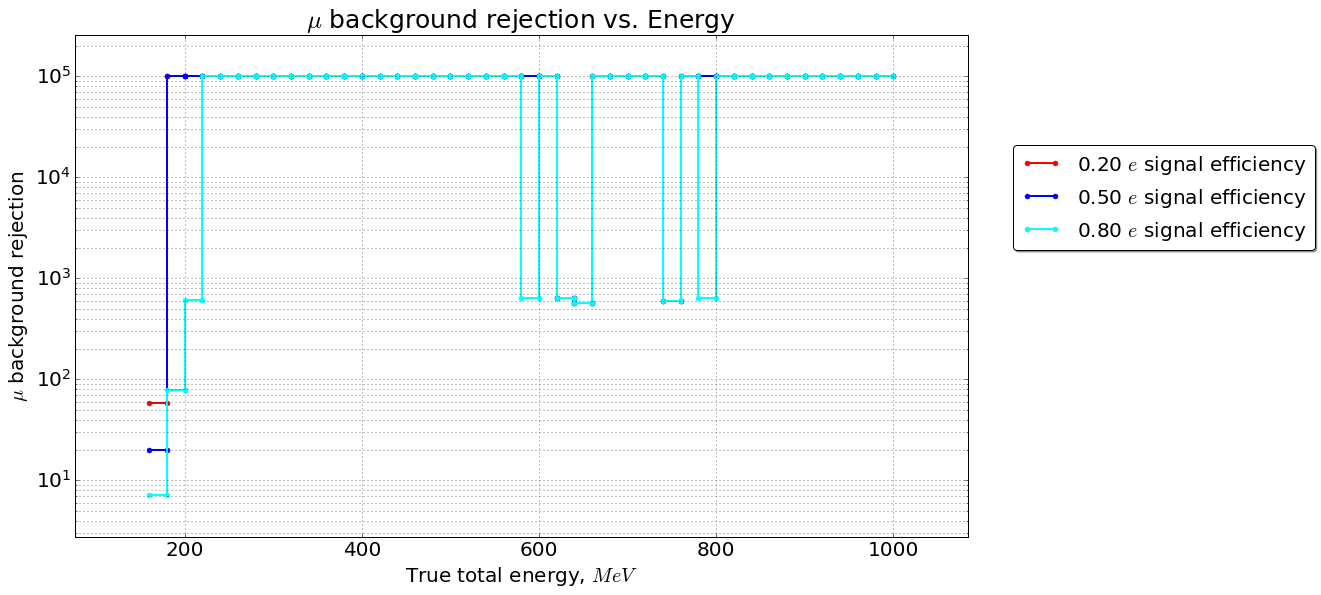

In [22]:
#num_samples = [45000, 45000, 45000]
#run_ids = ["20191024_164716", "20191024_165414", "20191024_170156"]
num_samples = [720000]
run_ids = ["20191017_113156"]

dump_dir = "/home/akajal/WatChMaL/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"
label_dict = {"gamma":0, "e":1, "mu":2}

for num_sample, run_id in zip(num_samples, run_ids):
    
    print("-------------------------------------------------------------")
    print("Plotting the ROC curve for LeNet CNN trained using {0} samples".format(num_sample))
    print("-------------------------------------------------------------")
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    test_softmax  = test_dump_np["softmax"].reshape(-1, 3)
    test_labels   = test_dump_np["labels"].reshape(-1)
    test_energies = test_dump_np["energies"].reshape(-1)
    
    plot_brj_vs_energy(test_softmax, test_labels, test_energies, label_dict, "e", "mu", num_bins=50, min_energy=0,
                       max_energy=1000, lgd_loc=(1.4, 0.8), colors=["red", "blue", "cyan"], log=True, show_plot=True)